# Data Understanding - Server Logs
### 1. Nguồn dữ liệu
### 2. Mô tả trường thông tin
#### Dữ liệu log có cấu trúc gồm các trường chính:
| **Tên Trường**        | **Kiểu Dữ Liệu**       | **Mô Tả Ý Nghĩa**                                                      |
|-----------------------|------------------------|-------------------------------------------------------------------------|
| `std`                 | String                 | Loại log: `stdout` (log bình thường) hoặc `stderr` (log lỗi).                |
| `remote_address`      | String                 | Địa chỉ IP của máy khách.                                      |
| `remote_user`         | String                 | Tên người dùng (dấu `-` nếu không có thông tin).     |
| `datetime`            | Datetime               | Thời gian và ngày giờ của request, định dạng theo chuẩn ISO8601: `yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS+hh:mm`|
| `method`              | String                 | Phương thức HTTP (ví dụ: GET, POST, PUT, DELETE,...)                 |
| `path`                | String                 | Đường dẫnđược truy cập trên máy chủ (ví dụ: `/status`, `/api/data`)           |
| `header`              | String                 | Phiên bản giao thức HTTP (ví dụ: `HTTP/1.1`).                           |
| `status`              | Integer                | Mã trạng thái HTTP trả về (ví dụ: `200`, `404`, `500`)                |
| `bytes_sent`          | Integer                | Số byte dữ liệu đã được gửi trong phản hồi (response)                |
| `referer`             | String                 | URL nguồn (referer) của request           |
| `user_agent`          | String                 | Thông tin về trình duyệt hoặc công cụ gửi request. |
### 3. Tách các dòng log thành các trường dữ liệu
#### Ví dụ ta có dữ liệu như sau:<br>2024-11-30T13:51:41.272335253+07:00 stdout F 127.0.0.1 - - [30/Nov/2024:06:51:41 +0000] "GET /status HTTP/1.1" 200 1164 "-" "kong-ingress-controller/3.3.1"<br>2024-11-30T13:51:42.210291667+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status HTTP/1.1" 200 1165 "-" "kube-probe/1.27"<br>2024-11-30T13:51:42.213094133+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status/ready HTTP/1.1" 200 19 "-" "kube-probe/1.27"

#### Mục tiêu là tách các trường dữ liệu và đưa về dạng:<br>
| std    | remote_address | remote_user | datetime                    | method | path          | header   | status | bytes_sent | referer | user_agent                     |
|--------|----------------|-------------|-----------------------------|--------|---------------|----------|--------|------------|---------|--------------------------------|
| stdout | 127.0.0.1      | -           | 30/Nov/2024:06:51:41 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1164       | -       | kong-ingress-controller/3.3.1 |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1165       | -       | kube-probe/1.27               |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status/ready | HTTP/1.1 | 200    | 19         | -       | kube-probe/1.27               |
#### Để đạt được các trường dữ liệu đó, ta cần thiết kế biểu thức regex tương ứng: <br> 
```regex
^
\S+                              # Phần đầu dòng, bỏ qua chuỗi không chứa khoảng trắng.
 (?P<std>\S+)                    # Nhóm `std`: stdout/stderr.
 \S+                             # Bỏ qua một chuỗi không chứa khoảng trắng.
 (?P<remote_address>\d+\.\d+\.\d+\.\d+) # Nhóm `remote_address`: Địa chỉ IP (IPv4).
 -                               # Ký tự gạch ngang.
 (?P<remote_user>[^ ]*)          # Nhóm `remote_user`: Tên người dùng (hoặc trống: `-`).
 \[(?P<datetime>[^\]]+)\]        # Nhóm `datetime`: Thời gian (nằm trong dấu `[]`).
 "(?P<method>\w+)                # Nhóm `method`: Phương thức HTTP (GET, POST,...).
  (?P<path>[^\s]+)               # Nhóm `path`: Đường dẫn truy cập.
  (?P<header>[^\"]+)"            # Nhóm `header`: Phiên bản giao thức (HTTP/1.1).
 (?P<status>\d+)                 # Nhóm `status`: Mã trạng thái HTTP (200, 404,...).
 (?P<bytes_sent>\d+)             # Nhóm `bytes_sent`: Số byte đã gửi.
 "(?P<referer>[^\"]*)"           # Nhóm `referer`: URL nguồn (có thể trống: `-`).
 "(?P<user_agent>[^\"]*)"        # Nhóm `user_agent`: Thông tin User-Agent.

In [1]:
import sys
import os
module_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module"
if module_path not in sys.path:
    sys.path.append(module_path)
from logtransform import LogTransform

In [2]:
source_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/log/0.log.20241201-211909"
destination_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/data/parsed_logs.csv"
log_pattern= r'^\S+ (?P<std>\S+) \S+ (?P<remote_address>\d+\.\d+\.\d+\.\d+) - (?P<remote_user>[^ ]*) \[(?P<datetime>[^\]]+)\] "(?P<method>\w+) (?P<path>[^\s]+) (?P<header>[^\"]+)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referer>[^\"]*)" "(?P<user_agent>[^\"]*)"'

In [3]:
logtransform = LogTransform(source_path)
df = logtransform.read_log_file(log_pattern)
df = logtransform.transform(df)
df.to_csv(destination_path)


/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/logtransform.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})
/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/logtransform.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['method'] = df['method'].replace({'GET': 0, 'POST': 1})


In [4]:
list(df["user_agent"].unique())

['kong-ingress-controller/3.3.1',
 'kube-probe/1.27',
 'otelcol-contrib/0.89.0',
 'python-requests/2.32.2',
 'HiRangDong/36 CFNetwork/1568.200.51 Darwin/24.1.0',
 'okhttp/4.12.0',
 'lua-resty-http/0.06 (Lua) ngx_lua/10020',
 'Dalvik/2.1.0 (Linux; U; Android 8.0.0; SM-G950U1 Build/R16NW)',
 'VTHome_Dev/6 CFNetwork/1568.200.51 Darwin/24.1.0',
 'VTHome_Dev/2 CFNetwork/1485 Darwin/23.1.0',
 'VTHome_Dev/21 CFNetwork/1568.200.51 Darwin/24.1.0',
 'okhttp/4.9.2',
 'RestSharp/106.11.4.0',
 'Apache-HttpClient/4.5.13 (Java/1.8.0_342)',
 'VTHome_Dev/44 CFNetwork/1568.200.51 Darwin/24.1.0',
 'Dalvik/2.1.0 (Linux; U; Android 12; Pixel 3a Build/SP2A.220505.008)',
 'Mozilla/5.0 (iPhone; CPU iPhone OS 16_3_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/131.0.6778.73 Mobile/15E148 Safari/604.1',
 'Go-http-client/2.0',
 'VTHome_Dev/13 CFNetwork/1568.200.51 Darwin/24.1.0',
 'Dalvik/2.1.0 (Linux; U; Android 12; SM-F926B Build/SP2A.220305.013)com.maika.ui',
 'VTHome_Dev/6 CFNetwork/1498.700

In [5]:
df.head()

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11


In [6]:
df.isnull().sum()

std               0
remote_address    0
datetime          0
method            0
path              0
status            0
bytes_sent        0
referer           0
user_agent        0
day               0
hour              0
month             0
dtype: int64

In [7]:
df.nunique()

std                   2
remote_address       27
datetime          50089
method                2
path                100
status                5
bytes_sent          144
referer               3
user_agent           24
day                   2
hour                 24
month                 2
dtype: int64

4. Minh Hoạ Dữ Liệu


In [8]:
import sys
import os
module_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module"
if module_path not in sys.path:
    sys.path.append(module_path)
from visualize import Visualize

In [9]:
log_path = r"/Users/phamthiphuongthuy/Desktop/Intern/server_log/data/parsed_logs.csv"
visualizer = Visualize(log_path)

Số lượng lỗi qua thời gian

so luong loi va request hop le qua thoi gian
request_type  Hợp lệ  Lỗi
hour                     
0               2041   16
1               2043   20
2               1931   18
3               1987   28
4               2143   20
5               2168   16
6               2357   29
7               4405   55
8               4407   76
9               4293   53
10              4319   70
11              4057   45
12              4038   48
13              4187   45
14              2653   29
15              2051   16
16              2156   24
17              2153   25
18              2048   24
19              2050   16
20              2279   15
21              1923   24
22              2042   17
23              1926   25


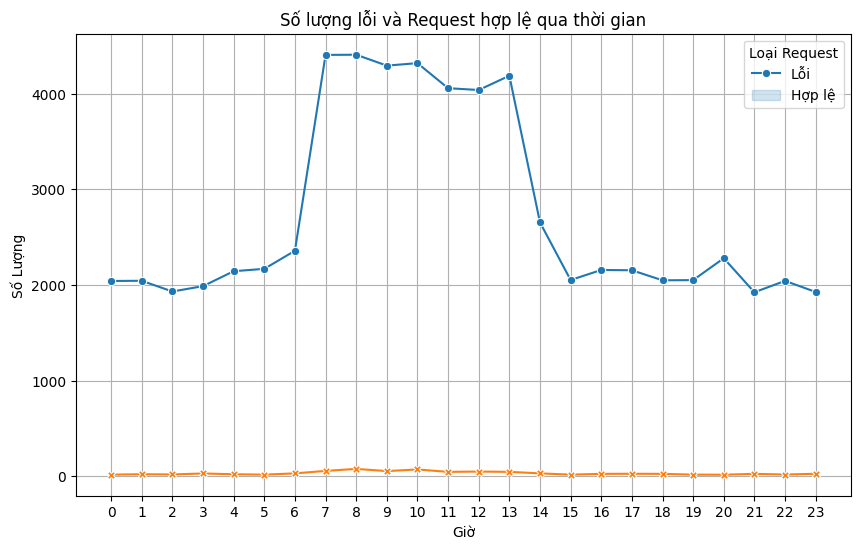

In [10]:
visualizer.plot_errors_over_time()

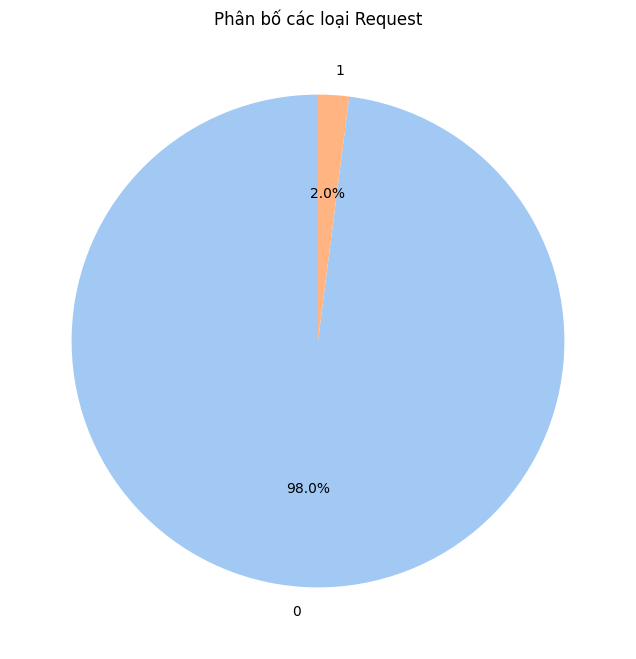

In [11]:
visualizer.plot_request_distribution()

/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/visualize.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_bytes_sent.index, y=hourly_bytes_sent.values, palette="viridis")


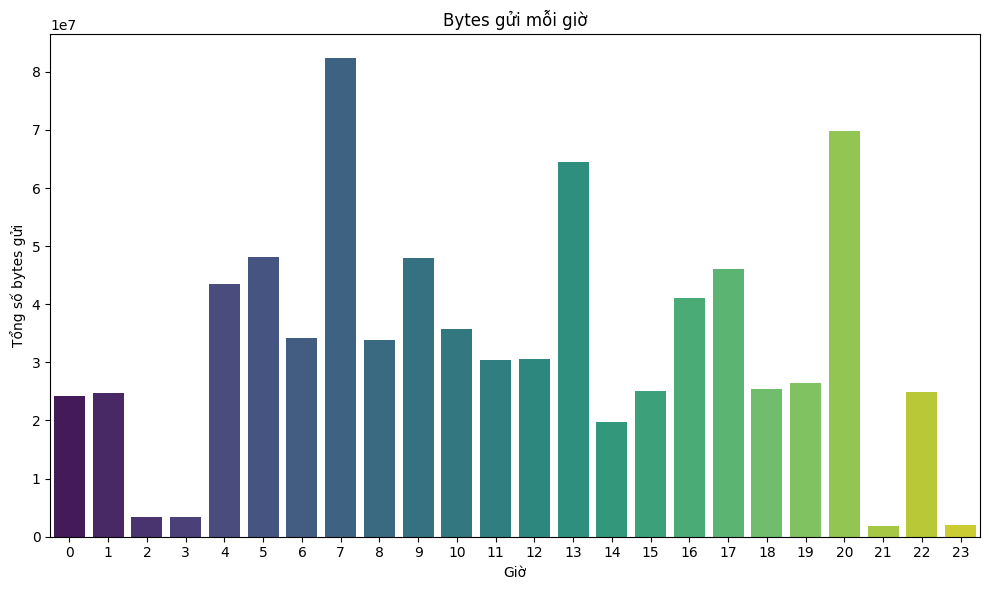

In [12]:
visualizer.plot_bytes_sent_per_hour()

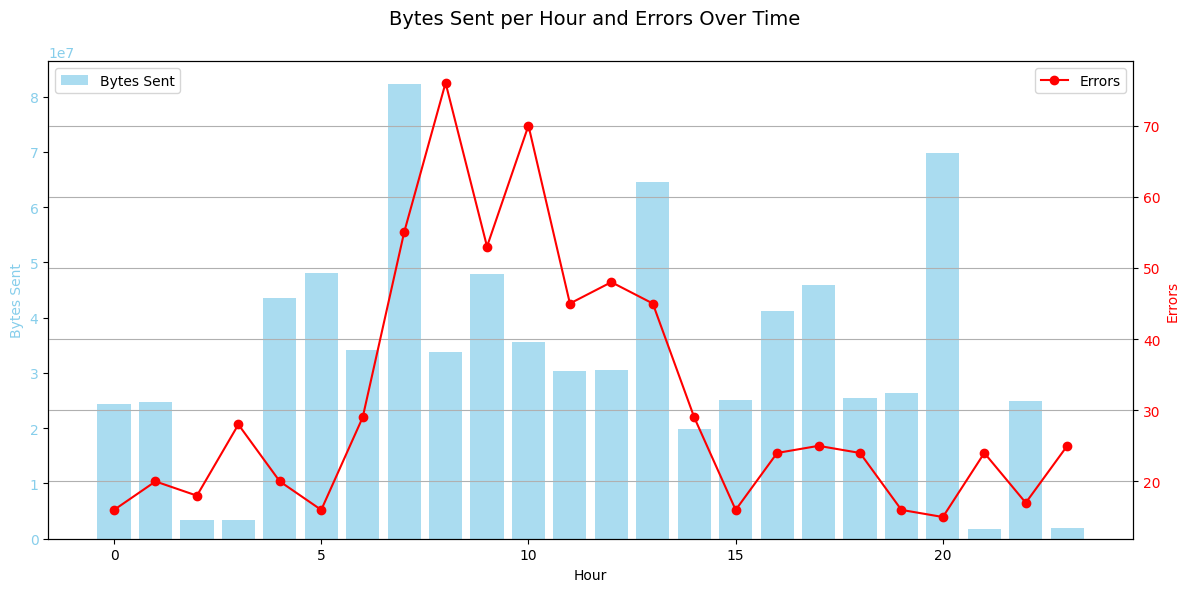

In [13]:
visualizer.plot_combined_chart()

/Users/phamthiphuongthuy/Desktop/Intern/server_log/main/module/visualize.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")


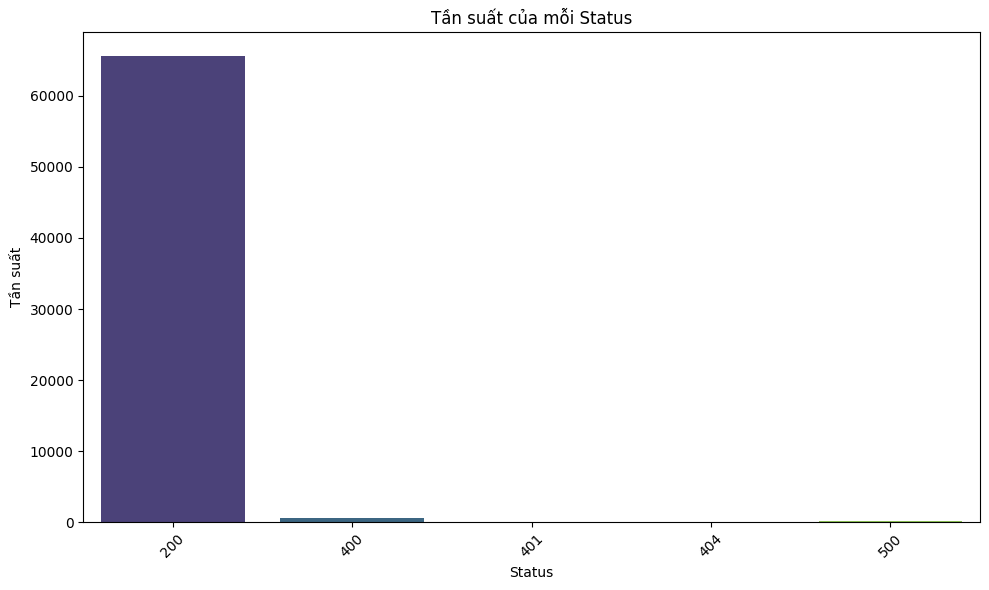

In [14]:
visualizer.plot_status_distribution()

In [15]:
df['error'] = df['status'].apply(lambda x: 1 if x != 200 else 0)

# Drop irrelevant columns and prepare cleaned data for embedding
cleaned_data = df.drop(columns=["std", "referer"])

[[-1.07186960e+04 -2.40447307e+00]
 [-1.07176960e+04 -2.40445834e+00]
 [-1.18636960e+04 -2.42134083e+00]
 ...
 [-1.07166958e+04 -2.78526946e+00]
 [ 1.80189304e+05  2.70944397e-02]
 [-1.07166958e+04 -2.78526946e+00]]


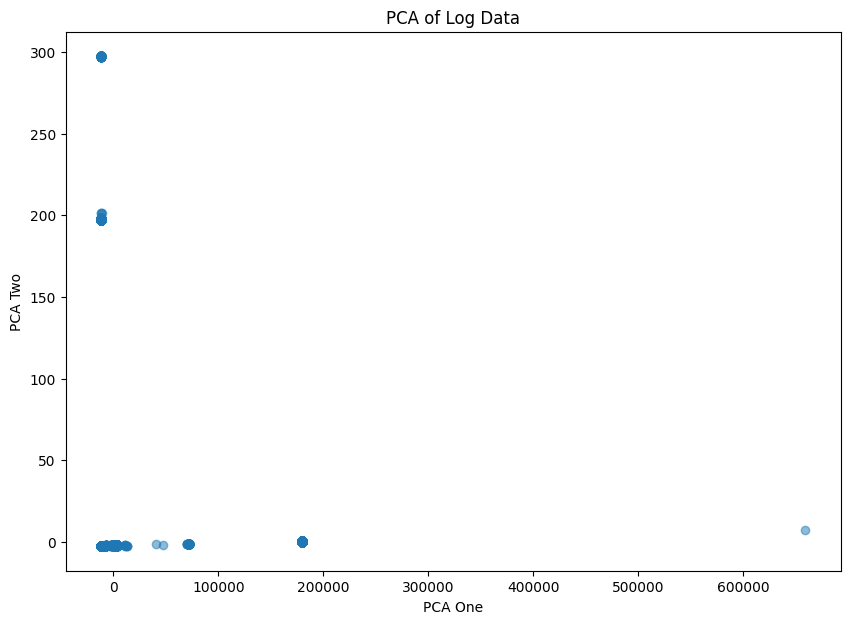

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select numerical columns for PCA
numerical_cols = ['method', 'status', 'bytes_sent', 'day', 'hour', 'month', 'error']
df_numerical = df[numerical_cols]

# Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_numerical)
print(pca_result)

# Add PCA results to the dataframe
df['pca_one'] = pca_result[:, 0]
df['pca_two'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(10, 7))
plt.scatter(df['pca_one'], df['pca_two'], alpha=0.5)
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.title('PCA of Log Data')
plt.show()

In [28]:
import pandas as pd
import torch
import torch.nn as nn


status_values = df['status'].values

# Convert to a tensor
status_tensor = torch.tensor(status_values, dtype=torch.long)

# Define an embedding layer for the 'status' column
# Assuming the range of 'status' is within a manageable number of unique values
embedding_layer = nn.Embedding(num_embeddings=1000, embedding_dim=2)  # 1000 unique statuses, 4-dim embeddings

# Get embeddings for the 'status' values
embedded_status = embedding_layer(status_tensor)

# Convert embeddings to a DataFrame for better visualization
embedded_status_df = pd.DataFrame(embedded_status.detach().numpy(), columns=[f"Dim_{i+1}" for i in range(embedded_status.size(1))])

# Display the first few rows of the embeddings
embedded_status_df


#import ace_tools_open as tools; tools.display_dataframe_to_user(name="Status Embeddings", dataframe=embedded_status_df.head())

,Dim_1,Dim_2
0,0.807123,-0.947628
1,0.807123,-0.947628
2,0.807123,-0.947628
3,0.807123,-0.947628
4,0.807123,-0.947628
...,...,...
66406,0.807123,-0.947628
66407,0.807123,-0.947628
66408,0.807123,-0.947628
66409,0.807123,-0.947628


In [18]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False)

# Apply One-Hot-Enconding for selected columns
encoded_data = encoder.fit_transform(df[['method', 'remote_address', 'path', 'path', 'status']])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['method', 'remote_address', 'path', 'path', 'status']))

# Appendind the encoded data to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Check the data after encoding
df.head()

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,...,path_/favicon.ico,path_/metrics,path_/sitemaps.xml,path_/status,path_/status/ready,status_200,status_400,status_401,status_404,status_500
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# Khởi tạo CountVectorizer cho các cột văn bản
vectorizer_referer = CountVectorizer()
referer_tfidf = vectorizer_referer.fit_transform(df['referer'])

vectorizer_user_agent = CountVectorizer()
user_agent_tfidf = vectorizer_user_agent.fit_transform(df['user_agent'])

# Chuyển các kết quả từ CountVectorizer thành DataFrame
referer_df = pd.DataFrame(referer_tfidf.toarray(), columns=vectorizer_referer.get_feature_names_out())
user_agent_df = pd.DataFrame(user_agent_tfidf.toarray(), columns=vectorizer_user_agent.get_feature_names_out())

# Thêm các cột đã được Vectorize vào DataFrame ban đầu
df = pd.concat([df, referer_df, user_agent_df], axis=1)

# Kiểm tra dữ liệu sau khi áp dụng CountVectorizer
df.head()


,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,...,r16nw,requests,restsharp,resty,safari,sm,sp2a,ui,vthome_dev,www
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,0,0
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,...,0,0,0,0,0,0,0,0,0,0
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,...,0,0,0,0,0,0,0,0,0,0
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,0,0
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.preprocessing import StandardScaler

# Khởi tạo StandardScaler
scaler = StandardScaler()

# Áp dụng StandardScaler cho cột 'bytes_sent'
df['bytes_sent_scaled'] = scaler.fit_transform(df[['bytes_sent']])
df['scaled_status'] = scaler.fit_transform(df[['status']])

# Kiểm tra dữ liệu sau khi áp dụng StandardScaler
df.head()


,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,...,restsharp,resty,safari,sm,sp2a,ui,vthome_dev,www,bytes_sent_scaled,scaled_status
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,-0.242426,-0.105839
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,...,0,0,0,0,0,0,0,0,-0.242403,-0.105839
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,...,0,0,0,0,0,0,0,0,-0.268322,-0.105839
3,0,127.0.0.1,2024-11-30 06:51:44+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,-0.242426,-0.105839
4,0,127.0.0.1,2024-11-30 06:51:47+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,...,0,0,0,0,0,0,0,0,-0.242426,-0.105839


In [21]:
# Step 1: Preprocess the parsed log data

# Convert 'datetime' to a proper timestamp format
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

# Convert 'status' and 'bytes_sent' to numeric
df['status'] = pd.to_numeric(df['status'], errors='coerce')
df['bytes_sent'] = pd.to_numeric(df['bytes_sent'], errors='coerce')

# Add an 'error' column (1 if status != 200, else 0)
df['error'] = (df['status'] != 200).astype(int)


In [22]:

# Step 2: Analyze error patterns

# Aggregate errors by time intervals (e.g., per minute)
errors_by_minute = df.set_index('datetime').resample('1T')['error'].sum()

# Identify peak error periods
peak_error_periods = errors_by_minute.sort_values(ascending=False).head(10)

# Calculate total errors and error proportion by user agent
errors_by_user_agent = (
    df.groupby('user_agent')['error']
    .sum()
    .sort_values(ascending=False)
)

# Calculate errors by path
errors_by_path = (
    df.groupby('path')['error']
    .sum()
    .sort_values(ascending=False)
)




/var/folders/2f/l2t6rv7j4pjfjqq_ymr89c2r0000gn/T/ipykernel_24078/3051309107.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  errors_by_minute = df.set_index('datetime').resample('1T')['error'].sum()


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Step 1: Prepare data for forecasting
# Use the aggregated errors by minute
error_time_series = errors_by_minute.reset_index()
error_time_series.columns = ['datetime', 'error_count']

# Create lag-based features for regression
for lag in range(1, 6):  # Lags for the past 5 minutes
    error_time_series[f'lag_{lag}'] = error_time_series['error_count'].shift(lag)

# Drop rows with NaN values caused by lagging
error_time_series.dropna(inplace=True)

error_time_series.head()

,datetime,error_count,lag_1,lag_2,lag_3,lag_4,lag_5
5,2024-11-30 06:56:00+00:00,1,1.0,0.0,0.0,0.0,0.0
6,2024-11-30 06:57:00+00:00,0,1.0,1.0,0.0,0.0,0.0
7,2024-11-30 06:58:00+00:00,0,0.0,1.0,1.0,0.0,0.0
8,2024-11-30 06:59:00+00:00,0,0.0,0.0,1.0,1.0,0.0
9,2024-11-30 07:00:00+00:00,0,0.0,0.0,0.0,1.0,1.0


In [24]:

# Step 2: Prepare features and target variable
X = error_time_series.drop(columns=['datetime', 'error_count'])
y = error_time_series['error_count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:

# Step 3: Train the forecasting model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [26]:

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)


In [27]:

# Step 5: Forecast future error counts
future_input = X.tail(1).values  # Last row of lagged data
forecast = []
for _ in range(5):  # Forecast next 5 minutes
    prediction = model.predict(future_input)[0]
    forecast.append(prediction)
    future_input = np.array(future_input[:, 1:].tolist()[0] + [prediction]).reshape(1, -1)  # Shift lag features and reshape

# Results: MSE and forecast
mse, forecast


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: Use

(np.float64(0.3969520400791128),
 [np.float64(0.01),
  np.float64(0.3540289139581037),
  np.float64(0.30590703067179303),
  np.float64(0.3797287292696807),
  np.float64(0.3757640488695908)])